<h1><center>Laboratorio 9: Optimización de modelos 💯</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliares: Catherine Benavides y Consuelo Rojas
- Ayudante: Nicolás Ojeda, Eduardo Moya

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Manuel Zamorano
- Nombre de alumno 2: Javier Urrutia 


### Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.

### Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Optimizar modelos usando `optuna`
- Recurrir a técnicas de *prunning*
- Forzar el aprendizaje de relaciones entre variables mediante *constraints*
- Fijar un pipeline con un modelo base que luego se irá optimizando.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

### **Link de repositorio de GitHub:** `https://github.com/JUrrutia10/Laboratorios-MDS/tree/main/lab9`

# Importamos librerias útiles

# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Como usted tuvo un rendimiento sobresaliente en el proyecto de caracterización de datos, Fiu lo contrata como *data scientist* de su emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('sales.csv')
df['date'] = pd.to_datetime(df['date'])

df.head()

C:\Users\jeus8\AppData\Local\Temp\ipykernel_15080\3184305967.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,1,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,2,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,3,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,4,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


In [2]:
df.dtypes

id                    int64
date         datetime64[ns]
city                 object
lat                 float64
long                float64
pop                   int64
shop                 object
brand                object
container            object
capacity             object
price               float64
quantity              int64
dtype: object

## 1 Generando un Baseline (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad.
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas.
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas.
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios.
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio?
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`?
7. Guarde ambos modelos en un archivo .pkl (uno cada uno)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import joblib

In [4]:
# 1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad.

df['date'] = pd.to_datetime(df['date'])

# Dividir los datos en características (X) y variable objetivo (y)
X = df.drop(columns=['id', 'quantity']).copy()
y = df['quantity'].copy()

# Dividir en conjunto de entrenamiento (70%) y un conjunto temporal (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividir el conjunto temporal en validación (20%) y prueba (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)  # 0.33 * 0.3 = 0.1

In [5]:
# 2. Implemente un FunctionTransformer para extraer el día, mes y año de la variable date. Guarde estas variables en el formato categorical de pandas.

def extract_date_features(df):
    if isinstance(df, pd.DataFrame):
        df = df.copy()
        if 'date' in df.columns:
            df['year'] = df['date'].dt.year.astype('category')
            df['month'] = df['date'].dt.month.astype('category')
            df['day'] = df['date'].dt.day.astype('category')
            return df.drop(columns='date')
    return df

date_transformer = FunctionTransformer(extract_date_features)

In [6]:
# 3. Implemente un ColumnTransformer para procesar de manera adecuada los datos numéricos y categóricos. Use OneHotEncoder para las variables categóricas.

categorical_features = ['city', 'shop', 'brand', 'container', 'capacity', 'year', 'month', 'day']
numerical_features = ['lat', 'long', 'pop', 'price']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]#,remainder='passthrough'
)

In [7]:
# 4. Guarde los pasos anteriores en un Pipeline, dejando como último paso el regresor DummyRegressor para generar predicciones en base a promedios.

pipeline = Pipeline(steps=[
    ('date_transform', date_transformer),
    ('preprocessor', preprocessor),
    ('regressor', DummyRegressor(strategy='mean'))
])

In [8]:
# 5. Entrene el pipeline anterior y reporte la métrica mean_absolute_error sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio?

# Entrenar pipeline
pipeline.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de validación
y_val_pred = pipeline.predict(X_val)

# Calcular el mean absolute error (MAE)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Mean Absolute Error on validation set: {mae}')

Mean Absolute Error on validation set: 13308.134750658153


El MAE indica, en promedio, cuántas unidades de la variable objetivo (cantidad vendida) difieren las predicciones del modelo de los valores reales. En este caso, el valor de 13308 significa que, en promedio, las predicciones del modelo tienen un error absoluto de aproximadamente 13308 unidades de cantidad vendida.

In [9]:
# 6. Finalmente, vuelva a entrenar el Pipeline pero esta vez usando XGBRegressor como modelo utilizando los parámetros por default. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el DummyRegressor?

# Actualizar el pipeline con XGBRegressor
xgb_pipeline = Pipeline(steps=[
    ('date_transform', date_transformer),
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

# Entrenar el pipeline con XGBRegressor
xgb_pipeline.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de validación con XGBRegressor
y_val_pred_xgb = xgb_pipeline.predict(X_val)

# Calcular el mean absolute error (MAE) para XGBRegressor
mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
print(f'Mean Absolute Error on validation set with XGBRegressor: {mae_xgb}')

Mean Absolute Error on validation set with XGBRegressor: 2504.8566180688836


El MAE obtenido con el `XGBRegressor` es 2504.8566180688836, mientras que el MAE obtenido con el `DummyRegressor` fue 13308.134750658153. El `XGBRegressor` redujo significativamente el MAE en comparación con el `DummyRegressor`, lo que indica que `XGBRegressor` es mucho más efectivo para predecir la cantidad vendida. Este menor MAE sugiere que las predicciones del `XGBRegressor` están, en promedio, mucho más cerca de los valores reales de ventas.

In [10]:
# 7. Guarde ambos modelos en un archivo .pkl (uno cada uno)

# Guardar el modelo DummyRegressor
joblib.dump(pipeline, 'dummy_regressor_model.pkl')

# Guardar el modelo XGBRegressor
joblib.dump(xgb_pipeline, 'xgb_regressor_model.pkl')

['xgb_regressor_model.pkl']

## 2. Forzando relaciones entre parámetros con XGBoost (1.0 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Para aplicar esta restricción apóyese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>. Hint: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación.

3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo?




In [11]:
def feat_names(x):
    # Crear el pipeline para obtener los nombres de las características después de la transformación
    temp_pipeline = Pipeline(steps=[
        ('date_transform', date_transformer),
        ('preprocessor', preprocessor)
    ])

    # Ajustar el pipeline temporal
    temp_pipeline.fit(x)

    # Obtener los nombres de las características después de la transformación
    feature_names = temp_pipeline.named_steps['preprocessor'].get_feature_names_out().copy()

    feature_names= [name.replace('cat__', '') for name in feature_names]
    feature_names= [name.replace('num__', '') for name in feature_names]
    return feature_names

In [12]:


# Crear el pipeline con XGBRegressor con una restricción monótona negativa en 'price'
xgb_pipeline = Pipeline(steps=[
    ('date_transform', date_transformer),
    ('preprocessor', preprocessor),
    ('to_dataframe', FunctionTransformer(func=lambda x: pd.DataFrame(x.todense(), columns=feat_names(X_train)))),
    ('model', XGBRegressor(monotone_constraints={'price': -1}))
])

# Entrenar el pipeline con la restricción monótona negativa
xgb_pipeline.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de validación con el modelo actualizado
y_val_pred_xgb_constrained = xgb_pipeline.predict(X_val)

# Calcular el mean absolute error (MAE) para el modelo con la restricción monótona negativa
mae_xgb_constrained = mean_absolute_error(y_val, y_val_pred_xgb_constrained)
print(f'Mean Absolute Error on validation set with XGBRegressor (monotonic constraint): {mae_xgb_constrained}')

Mean Absolute Error on validation set with XGBRegressor (monotonic constraint): 2574.8494157574683


## 3. Optimización de Hiperparámetros con Optuna (2.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se le pide:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)
- Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados?
- Fije el tiempo de entrenamiento a 5 minutos
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- Guardar su modelo en un archivo .pkl

In [13]:
import optuna

In [133]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define la función objetivo
def objective(trial):
    # Definir los hiperparámetros a ajustar
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }

    date_transformer = FunctionTransformer(extract_date_features)
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=trial.suggest_float('min_frequency', 0.0, 1.0)), categorical_features)
       ]
     )


    # Crear y entrenar el modelo XGBRegressor con los hiperparámetros dados
    model = XGBRegressor(**xgb_params, random_state=42)

    # Crear el pipeline
    pipeline = Pipeline(steps=[
        ('date_transform', date_transformer),
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Entrenar el pipeline con los datos de entrenamiento
    pipeline.fit(X_train, y_train)

    # Predecir sobre el conjunto de validación y calcular el MAE
    y_pred = pipeline.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    return mae

# Ejecutar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=300, show_progress_bar=True)

# Obtener el MAE y los mejores hiperparámetros encontrados
best_mae = study.best_value
best_params = study.best_params
num_trials = len(study.trials)
best_model=study.best_trial

print(f'Número de trials: {num_trials}')
print(f'MAE: {best_mae}')
print('Mejores hiperparámetros encontrados:')
for key, value in best_params.items():
    print(f'{key}: {value}')

TypeError: objective() takes 1 positional argument but 3 were given

In [130]:
best_model=study.best_trial


joblib.dump(best_model, 'mejor_modelo.pkl')

['mejor_modelo.pkl']

*  `learning_rate:` Es el tamaño del paso en el proceso de ajuste. Un valor más pequeño hace que el modelo avance más lentamente hacia la convergencia, lo que puede mejorar la precisión, pero también aumentar el tiempo de entrenamiento. El rango sugerido de (0.001, 0.1) tiene sentido ya que estos valores son típicos para el learning rate en modelos de gradient boosting.

* ` n_estimators:` Es el número de árboles de decisión a construir. Un mayor número de árboles puede mejorar la precisión del modelo, pero también aumentar el tiempo de entrenamiento. El rango sugerido de (50, 1000) tiene sentido para explorar una amplia gama de posibles valores.

*  `max_depth:` Es la profundidad máxima de cada árbol de decisión. Un valor más alto permite al modelo capturar relaciones más complejas en los datos, pero también puede llevar al sobreajuste. El rango sugerido de (3, 10) es típico para evitar sobreajustes y aún así permitir cierta complejidad en el modelo.

*  `max_leaves`: Es el número máximo de hojas en cada árbol de decisión. Controla la complejidad del árbol. El rango sugerido de (0, 100) es amplio para explorar diferentes niveles de complejidad.

*  `min_child_weight:` Es la cantidad mínima de instancias necesarias en cada nodo hoja. Ayuda a prevenir el sobreajuste. El rango sugerido de (1, 5) tiene sentido para evitar que los nodos hoja tengan muy pocas instancias.

*  `reg_alpha` y `reg_lambda`: Son términos de regularización que ayudan a controlar la complejidad del modelo y prevenir el sobreajuste. El rango sugerido de (0, 1) permite explorar diferentes niveles de regularización.

*  `min_frequency:` Es el hiperparámetro min_frequency del OneHotEncoder, que controla el número mínimo de veces que una categoría debe aparecer en el conjunto de datos para ser considerada. Un valor más alto puede reducir la dimensionalidad del conjunto de datos y mejorar la generalización del modelo.


El MAE obtenido en esta sección (1936.20) es menor que el MAE obtenido en la sección anterior (2504.86). Esto indica que el modelo entrenado con los hiperparámetros optimizados tiene un mejor rendimiento en la predicción de la demanda en comparación con el modelo que no tenía sus hiperparámetros ajustados.

Esto puede deberse a que el ajuste de los hiperparámetros permite al modelo adaptarse mejor a los datos y capturar las relaciones subyacentes entre las características y la variable objetivo. Específicamente, los hiperparámetros como `learning_rate`, `n_estimators`, `max_depth`, `min_child_weight`, `reg_alpha`, `reg_lambda`, y `min_frequency` pueden influir significativamente en la capacidad del modelo para capturar la complejidad del problema y evitar el sobreajuste.

## 4. Optimización de Hiperparámetros con Optuna y Prunners (1.7)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento?
- Utilizar `optuna.integration.XGBoostPruningCallback` como método de **Prunning**
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- Guardar su modelo en un archivo .pkl

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

In [144]:
from optuna.integration import XGBoostPruningCallback

optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna.logging.disable_default_handler()
def get_feature_names(preprocessor):
        # Ajustar el preprocesador temporalmente para obtener los nombres de las características
        temp_pipeline = Pipeline(steps=[
            ('date_transform', date_transformer),
            ('preprocessor', preprocessor)
        ])

        temp_pipeline.fit(X_train)

        feature_names = temp_pipeline.named_steps['preprocessor'].get_feature_names_out().copy()
        feature_names = [name.replace('cat__', '') for name in feature_names]
        feature_names = [name.replace('num__', '') for name in feature_names]
        return feature_names
def todf(x):
    if isinstance(x, np.ndarray):
        df = pd.DataFrame(x, columns=get_feature_names(preprocessortri))
    else:
        df = pd.DataFrame(x.todense(), columns=get_feature_names(preprocessortri))
    return df
# Define la función objetivo
def objective(trial):
    # Definir los hiperparámetros a ajustar
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
         
    }

    # Crear el modelo XGBRegressor con los hiperparámetros dados
    modelxgb = XGBRegressor(**xgb_params, random_state=42, enable_categorical=True, 
        eval_metric="mae", early_stopping_rounds=10,callbacks=[XGBoostPruningCallback(trial, "validation_0-mae")])

    date_transformer = FunctionTransformer(extract_date_features)
    global preprocessortri
    preprocessortri = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=trial.suggest_float('min_frequency', 0.0, 1.0)), categorical_features)
       ],remainder='passthrough'
     )
    


    pipelinexgb = Pipeline(steps=[
        ('date_transform', date_transformer),
        ('preprocessor', preprocessortri),
        ('to_dataframe', FunctionTransformer(func=todf)),
        ('regressor', modelxgb)
    ])
    

    
    
    X_train_tr=pipelinexgb[:-1].fit_transform(X_train)
    X_val_tr=pipelinexgb[:-1].transform(X_val)

    # Entrenar el pipeline con los datos de entrenamiento
    
    
    fitted=pipelinexgb[-1].fit(X_train_tr, y_train,eval_set=[(X_val_tr, y_val)])



    return fitted.best_score

# Ejecutar la optimización con Optuna
study2 = optuna.create_study(direction='minimize')
study2.optimize(objective, timeout=300, show_progress_bar=True)



   0%|          | 00:00/05:00

[0]	validation_0-mae:13261.54142
[1]	validation_0-mae:13215.28712
[2]	validation_0-mae:13170.82569
[3]	validation_0-mae:13126.17061
[4]	validation_0-mae:13083.29482
[5]	validation_0-mae:13039.88437
[6]	validation_0-mae:12998.49118
[7]	validation_0-mae:12956.14155
[8]	validation_0-mae:12915.49265
[9]	validation_0-mae:12873.91028
[10]	validation_0-mae:12834.30495
[11]	validation_0-mae:12794.91550
[12]	validation_0-mae:12755.41872
[13]	validation_0-mae:12715.69227
[14]	validation_0-mae:12676.97104
[15]	validation_0-mae:12637.79749
[16]	validation_0-mae:12599.71104
[17]	validation_0-mae:12561.33019
[18]	validation_0-mae:12523.20210
[19]	validation_0-mae:12486.24005
[20]	validation_0-mae:12449.02748
[21]	validation_0-mae:12412.91750
[22]	validation_0-mae:12376.74293
[23]	validation_0-mae:12341.69808
[24]	validation_0-mae:12306.13092
[25]	validation_0-mae:12271.78704
[26]	validation_0-mae:12238.05402
[27]	validation_0-mae:12204.61585
[28]	validation_0-mae:12170.89529
[29]	validation_0-mae:12

In [145]:
# Obtener el MAE y los mejores hiperparámetros encontrados
best_mae2 = study2.best_value
best_params2 = study2.best_params
num_trials2 = len(study2.trials)

print(f'Número de trials: {num_trials2}')
print(f'MAE: {best_mae2}')
print('Mejores hiperparámetros encontrados:')
for key, value in best_params2.items():
    print(f'{key}: {value}')

Número de trials: 146
MAE: 1977.3430340388747
Mejores hiperparámetros encontrados:
learning_rate: 0.0888616337968059
n_estimators: 676
max_depth: 8
max_leaves: 77
min_child_weight: 5
reg_alpha: 0.5944329069656108
reg_lambda: 0.20385536570632837
min_frequency: 0.001186848304714076


In [146]:
# Guardar el mejor modelo en un archivo .pkl
best_model_callback = study2.best_trial

joblib.dump(best_model_callback, 'mejor_modelo_callback.pkl')

['mejor_modelo_callback.pkl']


El pruning es una técnica utilizada en el entrenamiento de modelos de aprendizaje automático para evitar el sobreajuste y acelerar el proceso de optimización. Consiste en detener el entrenamiento de un modelo cuando no se observa una mejora significativa en una métrica de evaluación durante un cierto número de iteraciones consecutivas.

Cuando se utiliza pruning en la optimización de hiperparámetros con Optuna, se evalúa la métrica de interés en cada iteración del entrenamiento y se detiene prematuramente cualquier ensayo que no muestre una mejora significativa en la métrica de evaluación, según ciertos criterios de parada definidos.

En los resultados se ve que se tiene un MAE un poco mayor para este modelo cerca de 50 puntos mas, tiene sentido ya que se evita el sobre ajuste del modelo, es probable que en el test, este modelo tenga mejor resultado que el anterior comparando metricas de training con test.

## 5. Visualizaciones (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gráfico de historial de optimización
2. Gráfico de coordenadas paralelas
3. Gráfico de importancia de hiperparámetros

Comente sus resultados:

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados?
5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas?
6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo?

In [147]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

In [155]:
plot_optimization_history(study2)


segun el grafico desde el el trial 26 baja bastante el valor del mae, se estabiliza casi en el minimo en el trial 44

In [149]:
plot_parallel_coordinate(study2)


a partir de este grafico se puede notar que los trials con valores objetivos(MAE) mas bajos tienden a tener el maximo learning rate posible, entre 4-5 min_child_weight, el min_frequency muy bajo, los otros hiper parametros varian harto.

In [150]:
plot_param_importances(study2)

claramente el hiperparametro con mayor importancia es min_frequency y con gran diferencia con los otros, esto es debido que este hiper parametro es el que determina las variables que pasan por el onehotencoder, por lo que afecta en gran medida el modelo, ya que puede disminuir bastante el numero de columnas del dataframe.

## 6. Síntesis de resultados (0.3)

Finalmente:

1. Genere una tabla resumen del MAE obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning.
2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento?
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE.
4. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto?

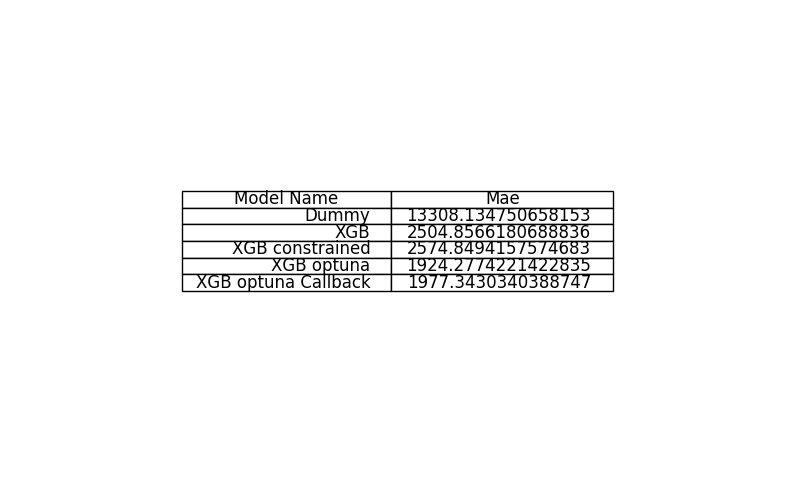

In [156]:
import matplotlib.pyplot as plt
metric_names = ['Model Name', 'Mae']
metric_values = [
    ['Dummy', mae],
    ['XGB', mae_xgb],
    ['XGB constrained', mae_xgb_constrained],
    ['XGB optuna', best_mae],
    ['XGB optuna Callback', best_mae2]
]

# Crear una figura y un eje
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Ocultar los ejes
ax.axis('off')

# Crear una tabla
table2 = ax.table(cellText=metric_values, colLabels=metric_names, loc='center')

# Ajustar el tamaño de la fuente en la tabla
table2.auto_set_font_size(False)
table2.set_fontsize(12)

# Ajustar el ancho de las columnas
table2.auto_set_column_width(col=list(range(len(metric_names))))

# Mostrar la tabla
plt.show()

solo por el valor del Mae de la data de validacion se puede concluir que el cuarto modelo, el primero con optuna es el mejor aunque la diferencia es bastante baja con el ultimo.

In [157]:
def objectiveX(trial,X,Y):
    # Definir los hiperparámetros a ajustar
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }

    date_transformer = FunctionTransformer(extract_date_features)
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=trial.suggest_float('min_frequency', 0.0, 1.0)), categorical_features)
       ]
     )


    # Crear y entrenar el modelo XGBRegressor con los hiperparámetros dados
    model = XGBRegressor(**xgb_params, random_state=42)

    # Crear el pipeline
    pipeline = Pipeline(steps=[
        ('date_transform', date_transformer),
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Entrenar el pipeline con los datos de entrenamiento
    pipeline.fit(X_train, y_train)

    # Predecir sobre el conjunto de validación y calcular el MAE
    y_pred = pipeline.predict(X)
    mae = mean_absolute_error(Y, y_pred)

    return mae

In [158]:


modelopkl = joblib.load("mejor_modelo.pkl")

maetest=objectiveX(modelopkl,X_test,y_test)
print(f'Mean Absolute Error en test set Modelo optuna : {maetest}')


Mean Absolute Error en test set Modelo optuna : 1956.436683665109


como se puede notar para el mejor modelo hay una diferencia en el valor del mae del conjunto de validacion con el conjunto de test, pero es muy pequeña, solo de 32, que para este caso seria incluso menor a la diferencia que tenia con los otros modelos.



# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://media.tenor.com/8CT1AXElF_cAAAAC/gojo-satoru.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>